<a href="https://colab.research.google.com/github/davanstrien/people-iiif/blob/main/weighted_loss_wikidata_train_baseline_less_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 204kB 8.0MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 


In [2]:
from pathlib import Path
from numpy.random import RandomState
from toolz import itertoolz, dicttoolz
from fastai.vision.all import *
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = Path('/content/drive/MyDrive/IIIF_AI_project')

In [5]:
path

Path('/content/drive/MyDrive/IIIF_AI_project')

In [6]:
df = pd.read_csv(path/'wikidata_w_image-labels.csv')

In [7]:
df

,tgm,item,themeLabel,url,urlhash,label,dl_fpath
0,tgm002065,http://www.wikidata.org/entity/Q29384004,cigarette,http://commons.wikimedia.org/wiki/Special:FilePath/11-00%20A.M.%20Monday%2C%20May%209th%2C%201910.%20Newsies%20at%20Skeeter%27s%20Branch%2C%20Jefferson%20near%20Franklin.%20They%20were%20all%20smoking.%20Location-%20St.%20Louis%2C%20Missouri.%20MET%20DP352686.jpg,5476561517036506605,cigarette,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/5476561517036506605.jpg
1,tgm002065,http://www.wikidata.org/entity/Q29578945,cigarette,http://commons.wikimedia.org/wiki/Special:FilePath/Anonymous%20Olga%20Bozna%C5%84ska%20sitting%20on%20a%20sofa%20with%20a%20cigarette.jpg,2547666618636415996,cigarette,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/2547666618636415996.jpg
2,tgm002065,http://www.wikidata.org/entity/Q56713789,cigarette,http://commons.wikimedia.org/wiki/Special:FilePath/100D%20-%202%2C%20Acervo%20do%20Museu%20Paulista%20da%20USP.jpg,3108069741139737998,cigarette;portrait,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/3108069741139737998.jpg
3,tgm002065,http://www.wikidata.org/entity/Q56718359,cigarette,http://commons.wikimedia.org/wiki/Special:FilePath/4455D%20-%2001%2C%20Acervo%20do%20Museu%20Paulista%20da%20USP.jpg,6536074540519139147,cigarette;portrait,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/6536074540519139147.jpg
4,tgm002065,http://www.wikidata.org/entity/Q78123994,cigarette,http://commons.wikimedia.org/wiki/Special:FilePath/Avisgutter%20tar%20seg%20en%20r%C3%B8yk%20%281905%29.jpg,17560400556605834985,cigarette,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/17560400556605834985.jpg
...,...,...,...,...,...,...,...
12145,tgm000686,http://www.wikidata.org/entity/Q75691041,award,http://commons.wikimedia.org/wiki/Special:FilePath/-A%20man%20with%20a%20trophy%2C%20Builth%20Wells%20Golf%20Club%20%281293417%29.jpg,18274333717120672795,award,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/18274333717120672795.jpg
12146,tgm002207,http://www.wikidata.org/entity/Q78145666,coachman,http://commons.wikimedia.org/wiki/Special:FilePath/Slededrosjer%20ved%20Nationaltheatret.%20-%2013.02.1904%20-%20Anders%20Beer%20Wilse%20-%20Oslo%20Museum%20-%20OB.Y1410.jpg,4983334255754292679,coachman,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/4983334255754292679.jpg
12147,tgm003584,http://www.wikidata.org/entity/Q96181582,work,http://commons.wikimedia.org/wiki/Special:FilePath/Pea%20Pickers%20Line%20Up%20on%20Edge%20of%20Field%20at%20Weigh%20Scale%2C%20near%20Calipatria%2C%20Imperial%20Valley%2C%20California%2C%20February%20MET%20DP-14185-001.jpg,2158356187537040849,work,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/2158356187537040849.jpg
12148,tgm003584,http://www.wikidata.org/entity/Q96803013,work,http://commons.wikimedia.org/wiki/Special:FilePath/-Women%20Grinding%20Paint%2C%20Calcutta-%20MET%20DP332540.jpg,2470024329174724360,work,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/2470024329174724360.jpg


In [8]:
labels = list(itertoolz.concat(df.label.str.split(";").to_list()))

In [9]:
label_freqs = itertoolz.frequencies(labels)

In [10]:
label_freqs_ge_20 = dicttoolz.valfilter(lambda x: x>=20, label_freqs)

In [11]:
labels_ge_20 = list(label_freqs_ge_20.keys())

In [12]:
def check_in_freq(x):
    new_labels = []
    labels = x.split(";")
    for label in labels:
        if label in labels_ge_20:
            new_labels.append(label)
    return new_labels


In [13]:
df['filteredlabels'] = df.label.apply(check_in_freq)

In [14]:
df['filteredlabels'] = df['filteredlabels'].apply(";".join)

In [15]:
df['fname'] = df.dl_fpath.apply(lambda x: Path(x).name)

In [16]:
df.head(10)

,tgm,item,themeLabel,url,urlhash,label,dl_fpath,filteredlabels,fname
0,tgm002065,http://www.wikidata.org/entity/Q29384004,cigarette,http://commons.wikimedia.org/wiki/Special:FilePath/11-00%20A.M.%20Monday%2C%20May%209th%2C%201910.%20Newsies%20at%20Skeeter%27s%20Branch%2C%20Jefferson%20near%20Franklin.%20They%20were%20all%20smoking.%20Location-%20St.%20Louis%2C%20Missouri.%20MET%20DP352686.jpg,5476561517036506605,cigarette,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/5476561517036506605.jpg,,5476561517036506605.jpg
1,tgm002065,http://www.wikidata.org/entity/Q29578945,cigarette,http://commons.wikimedia.org/wiki/Special:FilePath/Anonymous%20Olga%20Bozna%C5%84ska%20sitting%20on%20a%20sofa%20with%20a%20cigarette.jpg,2547666618636415996,cigarette,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/2547666618636415996.jpg,,2547666618636415996.jpg
2,tgm002065,http://www.wikidata.org/entity/Q56713789,cigarette,http://commons.wikimedia.org/wiki/Special:FilePath/100D%20-%202%2C%20Acervo%20do%20Museu%20Paulista%20da%20USP.jpg,3108069741139737998,cigarette;portrait,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/3108069741139737998.jpg,portrait,3108069741139737998.jpg
3,tgm002065,http://www.wikidata.org/entity/Q56718359,cigarette,http://commons.wikimedia.org/wiki/Special:FilePath/4455D%20-%2001%2C%20Acervo%20do%20Museu%20Paulista%20da%20USP.jpg,6536074540519139147,cigarette;portrait,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/6536074540519139147.jpg,portrait,6536074540519139147.jpg
4,tgm002065,http://www.wikidata.org/entity/Q78123994,cigarette,http://commons.wikimedia.org/wiki/Special:FilePath/Avisgutter%20tar%20seg%20en%20r%C3%B8yk%20%281905%29.jpg,17560400556605834985,cigarette,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/17560400556605834985.jpg,,17560400556605834985.jpg
5,tgm009985,http://www.wikidata.org/entity/Q75592066,sport,http://commons.wikimedia.org/wiki/Special:FilePath/Two%20lady%20golfers%20beside%20a%20table%20with%20trophies%20outside%20Llandrindod%20Wells%20Golf%20Club%20pavilion%20%281293383%29.jpg,8213152228518742662,sport;award,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/8213152228518742662.jpg,sport;award,8213152228518742662.jpg
6,tgm009985,http://www.wikidata.org/entity/Q75592071,sport,http://commons.wikimedia.org/wiki/Special:FilePath/Six%20gentlemen%20golfers%20on%20a%20golf%20course%20%281293370%29.jpg,4004049890319824358,sport,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/4004049890319824358.jpg,sport,4004049890319824358.jpg
7,tgm009985,http://www.wikidata.org/entity/Q75592085,sport,http://commons.wikimedia.org/wiki/Special:FilePath/Man%20outside%20Llandrindod%20Wells%20Golf%20Club%20pavilion%20holding%20a%20cup%20%281293384%29.jpg,10632294988152710640,sport;award,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/10632294988152710640.jpg,sport;award,10632294988152710640.jpg
8,tgm009985,http://www.wikidata.org/entity/Q75592089,sport,http://commons.wikimedia.org/wiki/Special:FilePath/Gentleman%20and%20lady%20with%20golf%20clubs%20and%20three%20trophies%20%281293369%29.jpg,52560277270845413,sport;award,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/52560277270845413.jpg,sport;award,52560277270845413.jpg
9,tgm009985,http://www.wikidata.org/entity/Q75592118,sport,http://commons.wikimedia.org/wiki/Special:FilePath/Llandrindod%20golf%20course%20%281293397%29.jpg,8618717754527682585,sport,/content/drive/MyDrive/IIIF_AI_project/wikidata-images-labels/8618717754527682585.jpg,sport,8618717754527682585.jpg


In [19]:
dls = ImageDataLoaders.from_df(df, 
                               path=path/'wikidata-images',
                               fn_col='fname',
                               label_col='filteredlabels',
                               label_delim=";", 
                               valid_pct=0.3,
                               bs=64, 
                               item_tfms=Resize(254), 
                               batch_tfms=[Rotate(), 
                                           Contrast(),
                                           Saturation(),
                                           Warp(0.1), 
                                           RandomErasing(), 
                                           Normalize.from_stats(*imagenet_stats)])

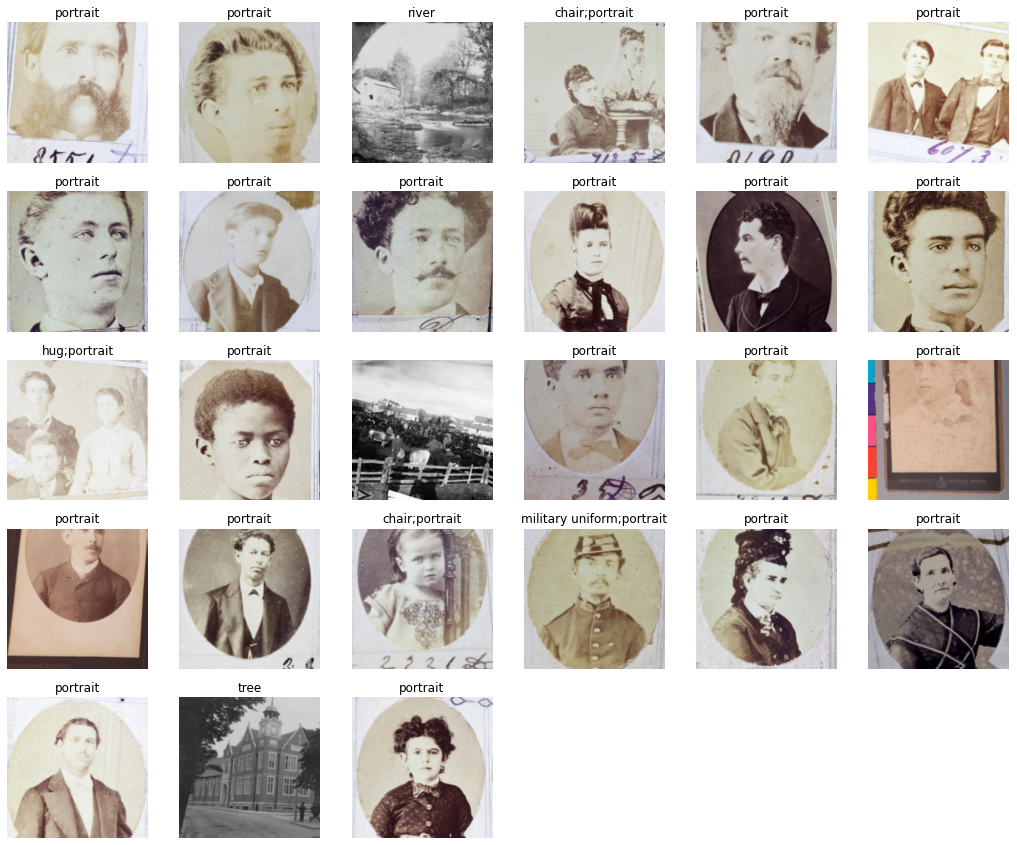

In [20]:
dls.show_batch(max_n=27)

In [21]:
labels_20 = list(filter(lambda x: x in labels_ge_20,labels))

In [22]:
len(np.unique(labels_20))

17

In [23]:
labels = list(itertoolz.concat(df.filteredlabels.str.split(";").to_list()))

In [24]:
labels = list(filter(lambda x: x!= '',labels))

In [25]:
list(itertoolz.unique(labels))

['portrait',
 'sport',
 'award',
 'river',
 'poet',
 'school',
 'dam',
 'tree',
 'bridge',
 'chair',
 'railway',
 'beach',
 'hug',
 'military uniform',
 'column',
 'fortification',
 'stained glass']

In [26]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', dls.vocab, labels)
class_weights

array([ 8.69877182, 17.2084399 ,  5.04196328,  1.03340501, 34.4168798 ,
       12.17828054, 27.29614604,  2.04017586,  4.34938591,  6.94375645,
        0.07384908,  6.88337596,  2.73905964, 12.17828054,  5.10702087,
       27.29614604,  3.53387605])

In [27]:
dls.vocab

['award', 'beach', 'bridge', 'chair', 'column', 'dam', 'fortification', 'hug', 'military uniform', 'poet', 'portrait', 'railway', 'river', 'school', 'sport', 'stained glass', 'tree']

In [28]:
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to('cuda')

In [29]:
from torch import nn

In [30]:
loss = nn.BCEWithLogitsLoss(weight=weights)

In [32]:
learn = cnn_learner(dls, 
                    resnet50,
                    loss_func=loss,
                    metrics=[F1ScoreMulti(average='macro'), 
                             accuracy_multi])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,f1_score,accuracy_multi,time
0,9.827535,7.107950,0.090368,0.579569,19:51
1,6.650186,3.321125,0.175114,0.923150,02:40
2,1.570272,0.366173,0.209091,0.986944,02:39
3,0.457922,0.219134,0.285076,0.987122,02:39
4,0.288556,0.179734,0.340662,0.987558,02:40


Better model found at epoch 0 with f1_score value: 0.09036829549886248.


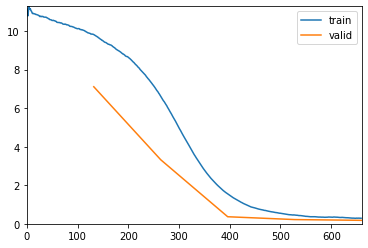

Better model found at epoch 1 with f1_score value: 0.175114193381726.
Better model found at epoch 2 with f1_score value: 0.2090914040662965.
Better model found at epoch 3 with f1_score value: 0.2850762580376349.
Better model found at epoch 4 with f1_score value: 0.3406617467067633.


epoch,train_loss,valid_loss,f1_score,accuracy_multi,time
0,0.199928,0.156106,0.441871,0.987961,02:42
1,0.180498,0.129866,0.492091,0.988574,02:42
2,0.142374,0.126487,0.554874,0.988929,02:43
3,0.130620,0.123143,0.555426,0.989527,02:43
4,0.132845,0.121549,0.610481,0.989994,02:42
5,0.108247,0.136349,0.600978,0.990301,02:43
6,0.109930,0.145559,0.614499,0.991172,02:46
7,0.101538,0.149186,0.599852,0.990640,02:44
8,0.102930,0.144418,0.551540,0.990463,02:43
9,0.080531,0.147544,0.634101,0.991350,02:44


Better model found at epoch 0 with f1_score value: 0.44187091376113175.


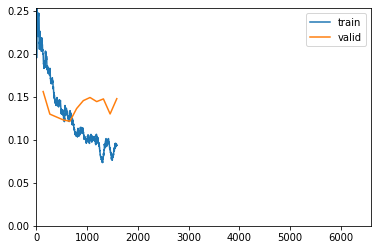

Better model found at epoch 1 with f1_score value: 0.4920911032156526.
Better model found at epoch 2 with f1_score value: 0.55487400679512.
Better model found at epoch 3 with f1_score value: 0.5554263248309669.
Better model found at epoch 4 with f1_score value: 0.610480505428916.
Better model found at epoch 6 with f1_score value: 0.6144987870315622.
Epoch 8: reducing lr to 7.230030215257753e-05
Better model found at epoch 9 with f1_score value: 0.6341005856137105.
Better model found at epoch 10 with f1_score value: 0.6525504493786654.
Better model found at epoch 11 with f1_score value: 0.656630393754336.
Epoch 12: reducing lr to 9.651595349770148e-05
No improvement since epoch 4: early stopping


In [33]:
learn.fine_tune(50, freeze_epochs=5,
                cbs=[SaveModelCallback(monitor='f1_score'),
                     EarlyStoppingCallback(patience=8),
                     ReduceLROnPlateau(patience=4),
                     ShowGraphCallback()])

In [34]:
learn.validate()

(#3) [0.14781157672405243,0.656630393754336,0.9913499355316162]

In [36]:
dls = ImageDataLoaders.from_df(df, 
                               path=path/'wikidata-images',
                               fn_col='fname',
                               label_col='filteredlabels',
                               label_delim=";", 
                               valid_pct=0.3,
                               bs=32, 
                               item_tfms=Resize(512), 
                               batch_tfms=[Rotate(), 
                                           Contrast(),
                                           Saturation(),
                                           Warp(0.1), 
                                           RandomErasing(), 
                                           Normalize.from_stats(*imagenet_stats)])

In [37]:
learn.dls = dls

epoch,train_loss,valid_loss,f1_score,accuracy_multi,time
0,0.122108,0.109598,0.720556,0.991236,04:27
1,0.119883,0.097610,0.743562,0.991720,04:21
2,0.108559,0.097506,0.734738,0.991736,04:22
3,0.097496,0.102984,0.728624,0.992092,04:22
4,0.095241,0.086547,0.751908,0.992108,04:22
5,0.110416,0.125584,0.711487,0.991914,04:22
6,0.119276,0.103608,0.704344,0.991914,04:22
7,0.088801,0.096084,0.737644,0.991753,04:22
8,0.109920,0.098706,0.733173,0.992576,04:21
9,0.081003,0.112590,0.755320,0.992705,04:22


Better model found at epoch 0 with f1_score value: 0.7205558156266682.


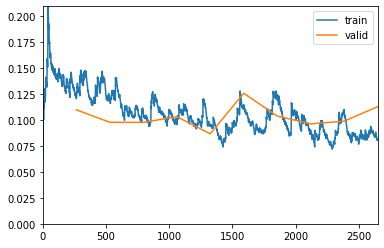

Better model found at epoch 1 with f1_score value: 0.7435620010726359.
Better model found at epoch 4 with f1_score value: 0.7519079265427511.
Epoch 8: reducing lr to 0.00019607886905630552
Better model found at epoch 9 with f1_score value: 0.755319648153126.


epoch,train_loss,valid_loss,f1_score,accuracy_multi,time
0,0.072707,0.138598,0.751500,0.992543,05:14
1,0.074822,0.112591,0.779255,0.992850,05:13
2,0.056149,0.122437,0.756154,0.992576,05:13
3,0.053570,0.119632,0.765185,0.992721,05:13
4,0.062659,0.141741,0.724716,0.992785,05:14
5,0.058289,0.119085,0.754715,0.992898,05:14
6,0.082746,0.151928,0.697842,0.992221,05:13


Better model found at epoch 0 with f1_score value: 0.7515001949349036.


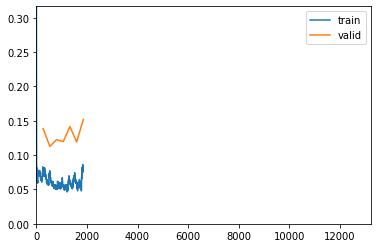

Better model found at epoch 1 with f1_score value: 0.7792549801606874.
Epoch 5: reducing lr to 4.7609256309474856e-05


epoch,train_loss,valid_loss,f1_score,accuracy_multi,time
0,0.072707,0.138598,0.751500,0.992543,05:14
1,0.074822,0.112591,0.779255,0.992850,05:13
2,0.056149,0.122437,0.756154,0.992576,05:13
3,0.053570,0.119632,0.765185,0.992721,05:13
4,0.062659,0.141741,0.724716,0.992785,05:14
5,0.058289,0.119085,0.754715,0.992898,05:14
6,0.082746,0.151928,0.697842,0.992221,05:13
7,0.077965,0.145199,0.706783,0.991866,05:14
8,0.090633,0.181560,0.686513,0.991640,05:14
9,0.070569,0.198322,0.671557,0.991607,05:12


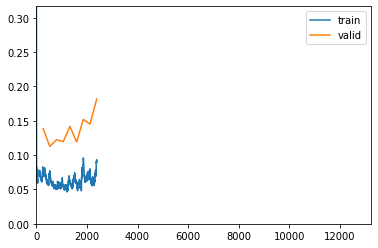

Epoch 9: reducing lr to 7.99726157606535e-05
No improvement since epoch 1: early stopping


In [38]:
learn.fine_tune(50, freeze_epochs=10,
                cbs=[SaveModelCallback(monitor='f1_score'),
                     EarlyStoppingCallback(patience=8),
                     ReduceLROnPlateau(patience=4),
                     ShowGraphCallback()])

In [39]:
from sklearn.metrics import classification_report

In [40]:
y_pred, y_true = learn.get_preds()

In [41]:
print(classification_report(y_true, y_pred>0.50, target_names=dls.vocab, zero_division=1))

                  precision    recall  f1-score   support

           award       1.00      0.90      0.95        30
           beach       0.58      1.00      0.73        11
          bridge       0.80      0.34      0.48        47
           chair       0.92      0.55      0.69       259
          column       0.80      0.67      0.73         6
             dam       1.00      1.00      1.00        16
   fortification       0.67      0.67      0.67         6
             hug       0.67      0.34      0.45       117
military uniform       0.89      0.76      0.82        45
            poet       0.80      0.85      0.82        33
        portrait       1.00      0.99      1.00      3195
         railway       0.78      0.81      0.80        43
           river       0.90      0.40      0.55        96
          school       0.87      0.65      0.74        20
           sport       0.96      0.96      0.96        49
   stained glass       0.78      1.00      0.88        14
            t